# Cluster all subtypes from each trial 

In [1]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
from scipy import cluster as scl
from scipy import stats, integrate
from matplotlib import pyplot as plt
from matplotlib import gridspec as gs
from matplotlib import pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import itertools
from nilearn import plotting as nplt
from functools import reduce

In [2]:
# load good stuff
%load_ext oct2py.ipython

In [3]:
# import warnings
# warnings.filterwarnings('ignore')

In [4]:
#custom function for key sorting element
import re

def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    '''
    alist.sort(key=natural_keys) sorts in human order
    http://nedbatchelder.com/blog/200712/human_sorting.html
    (See Toothy's implementation in the comments)
    '''
    return [ atoi(c) for c in re.split('(\d+)', text) ]

In [5]:
def make_boxes(mat, cl_def, pad=1, edge=False):
    """
    mat:    the matrix you want to do stuff to
    cl_def: a list of tuples where the first position is the 
            index of the first element in the cluster. the 
            second position is the index of the last element 
            in the cluster
    pad:    an integer value for the number of zero spaces to add
            around clusters
    edge:   boolean argument. If True, clusters at the corners will
            be drawn full. If False, clusters will be only drawn on
            the inside edge (no white line around the matrix).
            
    returns:
    omat:   the input matrix with the spaces added
    cmat_m: the overlayed cluster boxes in a masked array
    lmat_m: a mask of the added empty spaces
    ind:    the new index positions for the data (for x_ticks...)
    """
    # Extract the values
    starts = [i[0] for i in cl_def if not i[0]==0]
    if edge:
        starts = [i[0] for i in cl_def]
        stops = [i[1]+1 for i in cl_def]
    else:
        starts = [i[0] for i in cl_def if not i[0]==0]
        stops = [i[1]+1 for i in cl_def if not i[1]+1>=mat.shape[0]]
    # Find the breakpoints
    bkp = list(np.unique(starts + stops))
    n_bkp = len(bkp)
    # Convert to new indices
    run = 0
    ind = list()
    for i in np.arange(mat.shape[0]):
        if i in bkp:
            run += pad
        ind.append(i+run)

    # Make indices
    x = [i[0] for i in itertools.product(ind, ind)]
    y = [i[1] for i in itertools.product(ind, ind)]

    # Make new matrix
    omat = np.zeros([i+n_bkp*pad for i in mat.shape])
    omat[x, y] = mat.flatten()

    # Make a matrix for the clusters
    cmat = np.zeros_like(omat)
    # Make a matrix for the empty lines
    lmat = np.zeros_like(omat, dtype=bool)
    lmat[x,y] = True
    lmat_m = np.ma.masked_where(lmat, lmat)
    # Convert the input based breakpoints
    starts_c = [ind[i[0]]-pad for i in cl_def]
    stops_c = [ind[i[1]]+1 for i in cl_def]
    for i in np.arange(len(starts_c)):
        start = starts_c[i]
        stop = stops_c[i]
        if pad==1:
            start_ind = np.arange(start, start+pad)
            stop_ind = np.arange(stop, stop+pad)
        else:
            start_ind = np.arange(start, start+pad)
            stop_ind = np.arange(stop, stop+pad)
            
        if not start<=0 or edge:
            # Draw the top left corner first
            cmat[start_ind, start:stop] = i+1
            cmat[start:stop, start_ind] = i+1
        else:
            # Draw the bottom right corner next
            cmat[stop_ind, :stop+pad] = i+1
            cmat[:stop+pad, stop_ind] = i+1
            continue
        if not stop>=omat.shape[0] or edge:
            # Draw the bottom right corner next
            cmat[stop_ind, start:stop+pad] = i+1
            cmat[start:stop+pad, stop_ind] = i+1
    cmat_m = np.ma.masked_where(cmat==0, cmat)
    return omat, cmat_m, lmat_m, ind

In [14]:
#  Set path
path_root = '/media/yassine/data_disk/Drive/HCP2/subtypes_scores/26-10-2016/'
list_subtype_folder = ['subtype_3_spm_EMOTION_18-Oct-2017', 
                       'subtype_4_spm_EMOTION_18-Oct-2017',
                       'subtype_5_spm_EMOTION_18-Oct-2017',
                       'subtype_6_spm_EMOTION_18-Oct-2017',
                       'subtype_7_spm_EMOTION_18-Oct-2017',
                       'subtype_8_spm_EMOTION_18-Oct-2017',
                       'subtype_9_spm_EMOTION_18-Oct-2017',
                       'subtype_10_spm_EMOTION_18-Oct-2017']

## Merge all subtypes

In [15]:
# build subtype stack and save it
dict_tmp = {}
dict_tmp_json = {}

for ind_f , task_folder in enumerate(list_subtype_folder):
    
    # set path and task name
    path_subtype = os.path.join(path_root,task_folder)
    path_association =  os.path.join(path_subtype,'associations/');
    path_networks =  os.path.join(path_subtype,'networks/');
    nb_sbt = natural_keys(path_subtype)[9]
    task_name = natural_keys(path_subtype)[10][5:-1]
    
    # List trials
    list_trial  = [f for f in os.listdir(path_networks)]
    # List subtype
    list_subtype = ['sub{}'.format(ii) for ii in range(1,nb_sbt+1)]
    
    for ind_t,trial in enumerate(list_trial):
        
        #load matfile
        weight_file = os.path.join(path_networks,'{}/sbt_weights_net_{}.csv'.format(trial,trial))
        weight_df = pd.read_csv(weight_file)
        weight_df = weight_df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
        #column_names =np.append('ID', [x+'_{}'.format(str(nb_sbt)) for x in list_subtype])
        column_names =np.append('ID', [task_name[:3]+'_'+trial+'_'+x+'_{}'.format(str(nb_sbt)) for x in list_subtype])
        weight_df.columns= column_names
        # stack to dictionary
        dict_tmp[task_name+ "_" + trial + "_" + str(nb_sbt) + '_subtypes'] = weight_df
        
        # stack to json to be saved later
        dict_tmp_json[task_name+ "_" + trial + "_" + str(nb_sbt) + '_subtypes'] = weight_df.to_json(orient='split')

In [16]:
# Save all stack to json format for later use
import json
directory = os.path.join(path_root,task_name)
if not os.path.exists(directory):
    os.makedirs(directory)
json.dump(dict_tmp_json, open(os.path.join(directory,'{}_all_stack_subtypes.txt'.format(task_name)),'w'))

In [9]:
# to read it do
# dict_= json.load(open(os.path.join(directory,'{}_all_stack_subtypes.txt'.format(trial))))
# pd.read_json(dict_['EMOTION_story_5_subtypes'], orient='split').head()

In [10]:
# merge all subtype from the same task on the ID column
tab_keys = [i for i in dict_tmp.keys()]
tab_keys.sort(key=natural_keys)
concat_all_stack =[dict_tmp.get(tt) for tt in tab_keys]
merge_all_df = reduce(lambda left,right: pd.merge(left,right,how='left',on='ID'), concat_all_stack)
merge_all_df.to_csv(os.path.join(directory,'{}_merged_all_stack_subtypes.csv'.format(trial)))

In [17]:
# save all merged subtypes and trial
concat_all_stack =[dict_tmp.get(tt) for tt in dict_tmp.keys()]
merge_all_df = reduce(lambda left,right: pd.merge(left,right,how='left',on='ID'), concat_all_stack)
merge_all_df.to_csv(os.path.join(directory,'{}_merged_all_stack_subtypes.csv'.format(task_name)),index=False)

## Cluster all subtype

In [18]:
# Extract only subtype weight 
use_mat =  merge_all_df.drop(["ID"],axis=1).astype('float').as_matrix()

In [19]:
# Normalize these guys by column
use_mat_norm = (use_mat - np.mean(use_mat, 0))/np.std(use_mat, 0)

In [20]:
# Get the correlation of these
sbt_corr = np.corrcoef(use_mat_norm.T)
# And get the distance matrix of that
sbt_dist = scl.hierarchy.distance.pdist(use_mat_norm.T)
sbt_dist_mat = scl.hierarchy.distance.squareform(sbt_dist)

In [21]:
use_columns= merge_all_df.drop(["ID"],axis=1).columns.get_values()

In [22]:
# # Show that correlation
# gsp = gs.GridSpec(10, 20)
# f = plt.figure(figsize=(13,13))
# ax = f.add_subplot(gsp[:,:18])
# axcl = f.add_subplot(gsp[1:9,19])
# p = ax.imshow(sbt_corr,cmap = mpl.cm.get_cmap('jet', 100),interpolation='none')
# tmp = ax.set_yticks(range(len(use_columns)))
# tmp = ax.set_yticklabels(use_columns)
# tmp = ax.set_xticks(range(len(use_columns)))
# tmp = ax.set_xticklabels(use_columns, rotation=90)
# tmp = f.colorbar(p, cax=axcl)
# tmp = f.suptitle('Correlation Matrix',y=0.9,x=0.45)

In [23]:
# # Show that distance
# gsp = gs.GridSpec(10, 20)
# f = plt.figure(figsize=(13,13))
# ax = f.add_subplot(gsp[:,:18])
# axcl = f.add_subplot(gsp[1:9,19])
# p = ax.imshow(sbt_dist_mat,cmap = mpl.cm.hot,interpolation='none')
# tmp = ax.set_yticks(range(len(use_columns)))
# tmp = ax.set_yticklabels(use_columns)
# tmp = ax.set_xticks(range(len(use_columns)))
# tmp = ax.set_xticklabels(use_columns, rotation=90)
# tmp = f.colorbar(p, cax=axcl)
# tmp = f.suptitle('Distance Matrix',y=0.9,x=0.45)

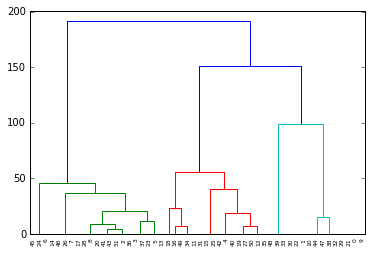

In [24]:
# Now do some clustering on that
n_sbt = 4
link = scl.hierarchy.linkage(sbt_dist, method='ward')
part = scl.hierarchy.fcluster(link, n_sbt, criterion='maxclust')
order = scl.hierarchy.dendrogram(link)['leaves']

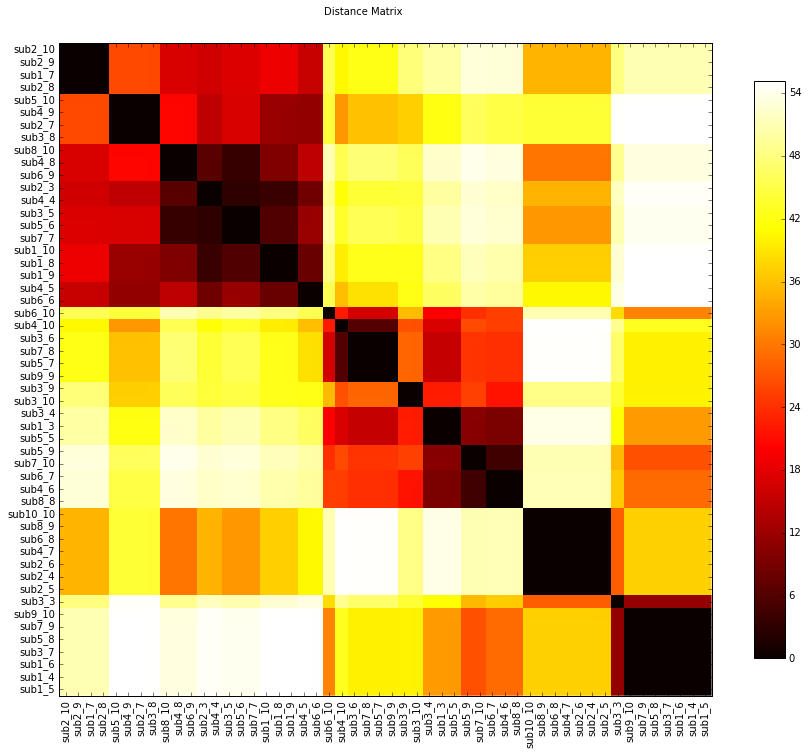

In [28]:
# Plot the distance matrix again, but now ordered by hierarchy
label_ord = [use_columns[ord] for ord in order]
gsp = gs.GridSpec(10, 20)
f = plt.figure(figsize=(13,13))
ax = f.add_subplot(gsp[:,:18])
axcl = f.add_subplot(gsp[1:9,19])
p = ax.imshow(sbt_dist_mat[order, :][:, order],cmap =mpl.cm.hot,interpolation='none')
tmp = ax.set_yticks(range(len(use_columns)))
tmp = ax.set_yticklabels(label_ord)
tmp = ax.set_xticks(range(len(use_columns)))
tmp = ax.set_xticklabels(label_ord, rotation=90)
tmp = f.colorbar(p, cax=axcl)
tmp = f.suptitle('Distance Matrix',y=0.9,x=0.45)

In [26]:
# Order clustered correlation matrix
t_clust = sbt_corr[order, :][:, order]
pco = part[order]

# Set start/stop boxes positions
cuts = [(np.min(np.argwhere(pco==i)), np.max(np.argwhere(pco==i)))for i in np.unique(pco)]

# Set color code
s3_colors = ["#f6afed",
             "#ec8b00",
             "#514c82"]

s4_colors = ["#f6afed",
             "#ec8b00",
             "#514c82",
             "#beb146"]
s5_colors = ["#cb5362",
            "#6ea84e",
            "#9d6cc1",
            "#bb873c",
            "#3fadaf"]

s6_colors = ["#cc5452",
            "#50ac72",
            "#c45ca2",
            "#929d3d",
            "#7879cd",
            "#c8803e"]

s7_colors = ["#bf61bb",
            "#60a75b",
            "#746cc9",
            "#b1963f",
            "#5aa4d1",
            "#cb623f",
            "#c8567a"]

s8_colors = ["#beb146",
             "#8f62ca",
             "#61af4b",
             "#c75d9c",
             "#4bb092",
             "#cb5253",
             "#6b8bcd",
             "#cb7d3e"]

s9_colors = ["#beb146",
             "#8f62ca",
             "#61af4b",
             "#c75d9c",
             "#4bb092",
             "#cb5253",
             "#6b8bcd",
             "#cb7d3e",
             "#717833"]


s10_colors =["#8562cc",
            "#60b14d",
            "#c361aa",
            "#bab241",
            "#688bcd",
            "#cd5136",
            "#4bb092",
            "#ca586f",
            "#717e37",
            "#c58443"]

lin3 = LinearSegmentedColormap.from_list(name='s3',
                                         colors = s3_colors,
                                         N=n_sbt)
lin4 = LinearSegmentedColormap.from_list(name='s4',
                                         colors = s4_colors,
                                         N=n_sbt)
lin5 = LinearSegmentedColormap.from_list(name='s5',
                                         colors = s5_colors,
                                         N=n_sbt)
lin6 = LinearSegmentedColormap.from_list(name='s6',
                                         colors = s6_colors,
                                         N=n_sbt)
lin7 = LinearSegmentedColormap.from_list(name='s7',
                                         colors = s7_colors,
                                         N=n_sbt)
lin8 = LinearSegmentedColormap.from_list(name='s8',
                                         colors = s8_colors,
                                         N=n_sbt)
lin9 = LinearSegmentedColormap.from_list(name='s9',
                                         colors = s9_colors,
                                         N=n_sbt)
lin10 = LinearSegmentedColormap.from_list(name='s10',
                                          colors = s10_colors,
                                          N=n_sbt)

In [27]:
# make strtucture to store different colors parameters
struc = {}
struc["3"]={}
struc["3"]["lin"] = lin3
struc["3"]["s_colors"] = s3_colors
struc["4"]={}
struc["4"]["lin"] = lin4
struc["4"]["s_colors"] = s4_colors
struc["5"]={}
struc["5"]["lin"] = lin5
struc["5"]["s_colors"] = s5_colors
struc["6"]={}
struc["6"]["lin"] = lin6
struc["6"]["s_colors"] = s6_colors
struc["7"]={}
struc["7"]["lin"] = lin7
struc["7"]["s_colors"] = s7_colors
struc["8"]={}
struc["8"]["lin"] = lin8
struc["8"]["s_colors"] = s8_colors
struc["9"]={}
struc["9"]["lin"] = lin9
struc["9"]["s_colors"] = s9_colors
struc["10"]={}
struc["10"]["lin"] = lin10
struc["10"]["s_colors"] = s10_colors

In [28]:
# Generate boxes
mat, cmat, lmat, ind = make_boxes(t_clust, cuts, 1)

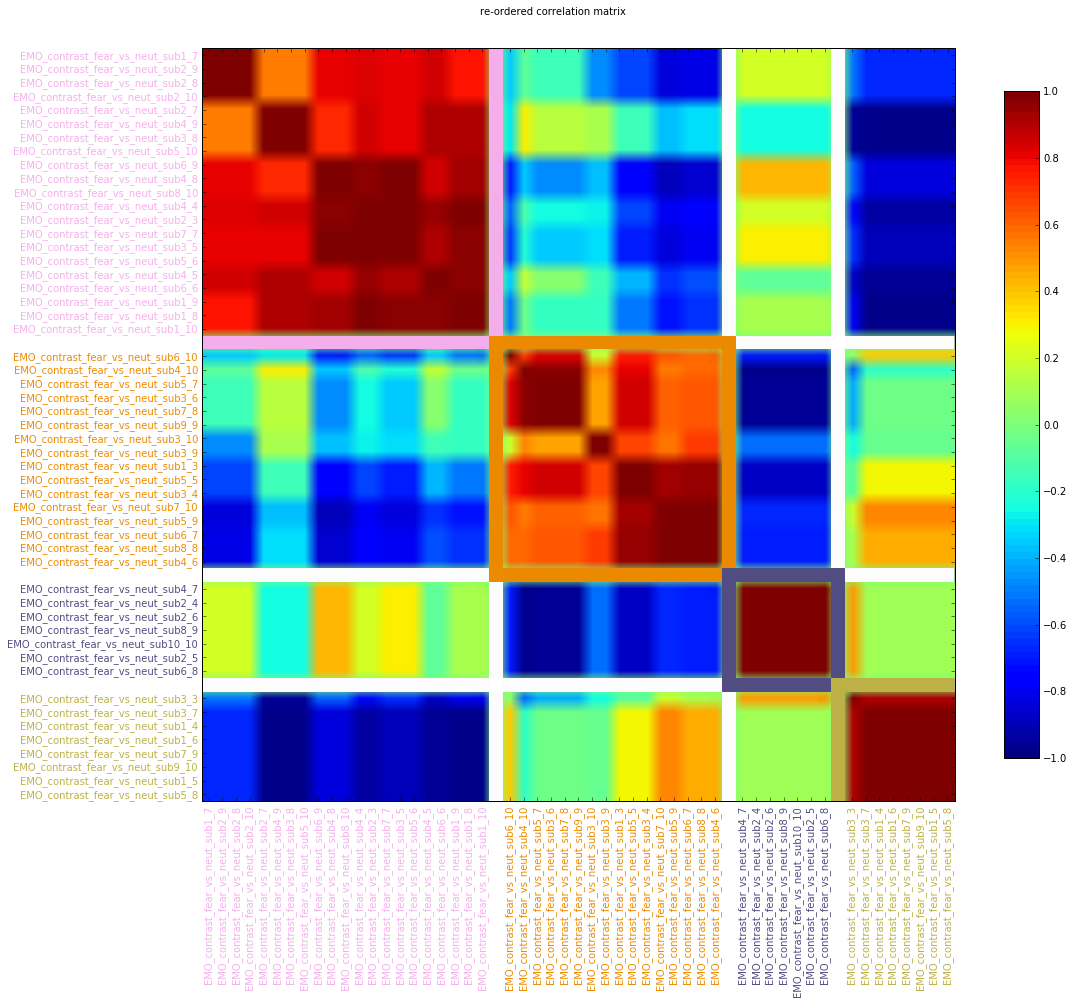

In [29]:
# Set figure
gsp = gs.GridSpec(10, 20)
f = plt.figure(figsize=(15,15))
ax = f.add_subplot(gsp[:,:18])
axcl = f.add_subplot(gsp[1:9,19])
p = ax.imshow(mat, cmap=mpl.cm.get_cmap('jet', 100), vmin=-1, vmax=1)
tmp = ax.imshow(lmat, cmap=plt.cm.Greys_r,interpolation='none')
tmp = ax.imshow(lmat, cmap=plt.cm.Greys, alpha=1,interpolation='none')
tmp = ax.imshow(cmat, cmap=struc[str(n_sbt)]['lin'],interpolation='none')
tmp = ax.set_yticks(ind)
tmp = ax.set_yticklabels(label_ord)
tmp = ax.set_xticks(ind)
tmp = ax.set_xticklabels(label_ord, rotation=90)
# set labels colors
colors = [struc[str(n_sbt)]['s_colors'][i-1] for i in pco]
for xtick,ytick,color in zip(ax.get_xticklabels(),ax.get_yticklabels(),colors):
    xtick.set_color(color)
    ytick.set_color(color)
tmp = f.colorbar(p, cax=axcl)
tmp = f.suptitle('re-ordered correlation matrix',y=0.9,x=0.45)
#f.savefig(os.path.join(path_root,'Figures/associations/pheno_clustered.svg'))

## cluster subtype 3 and 10

In [30]:
dict_tmp.keys()

dict_keys(['EMOTION_contrast_fear_vs_neut_5_subtypes', 'EMOTION_contrast_fear_vs_neut_8_subtypes', 'EMOTION_contrast_fear_vs_neut_10_subtypes', 'EMOTION_contrast_fear_vs_neut_9_subtypes', 'EMOTION_contrast_fear_vs_neut_6_subtypes', 'EMOTION_contrast_fear_vs_neut_4_subtypes', 'EMOTION_contrast_fear_vs_neut_3_subtypes', 'EMOTION_contrast_fear_vs_neut_7_subtypes'])

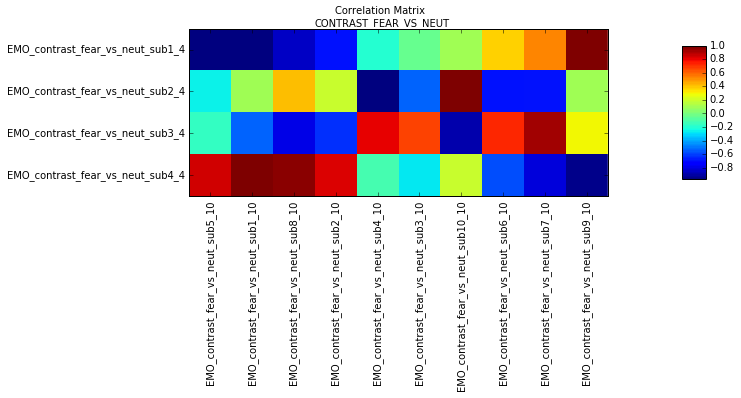

In [31]:
for ind_t,trial in enumerate(list_trial):
    # gather low and high subtypes
    subt_low_df = dict_tmp.get('{}_{}_{}_subtypes'.format(task_name,trial,n_sbt))
    subt_high_df = dict_tmp.get('{}_{}_10_subtypes'.format(task_name,trial))
    colname_subt_low=subt_low_df.columns.get_values()[1:]
    colname_subt_high=subt_high_df.columns.get_values()[1:]
    
    # Generate correl matrix rater by rater
    correl_store = np.zeros((len(colname_subt_low), len(colname_subt_high)))
    for ind_l, net_id_l in enumerate(colname_subt_low):
        var_1 = subt_low_df[net_id_l]
        for ind_h, net_id_h in enumerate(colname_subt_high):
            var_2 = subt_high_df[net_id_h]
            correl =np.corrcoef(var_1.astype('float'),var_2.astype('float'))
            # Save the correl
            correl_store[ind_l, ind_h] = correl[0,1]
            
    # sort matrix according
    ix_sort = 0
    correl_store_sorted = [correl_store[ii][np.argsort(correl_store[ix_sort])] for ii in range(correl_store.shape[0])]
    
    # Show that correlation
    gsp = gs.GridSpec(10, 20)
    f = plt.figure(figsize=(10,3))
    ax = f.add_subplot(gsp[:,:18])
    axcl = f.add_subplot(gsp[1:9,19])
    p = ax.imshow(correl_store_sorted,cmap = mpl.cm.get_cmap('jet', 100),interpolation='none')
    tmp = ax.set_yticks(range(len(colname_subt_low)))
    tmp = ax.set_yticklabels(colname_subt_low)
    tmp = ax.set_xticks(range(len(colname_subt_high)))
    tmp = ax.set_xticklabels(colname_subt_high[np.argsort(correl_store[ix_sort])], rotation=90)
    tmp = f.colorbar(p, cax=axcl)
    tmp = f.suptitle('Correlation Matrix \n{}'.format(str.upper(trial)),y=1,x=0.45)